# Comparing OpenVINO&trade; to TensorFlow Predictions

In this notebook, we'll go through how to perform predictions on our 3D U-Net using both TensorFlow and OpenVINO&trade;.  You should be able to see that OpenVINO&trade; inference gives a significant speedup to these predictions.

We'll assume that you already ran `train.py` and have trained a TensorFlow 3D U-Net model on the BraTS Medical Decathlon dataset.  We'll further assume that you have converted the final TensorFlow 3D U-Net model to OpenVINO&trade; by running something like:

```
source /opt/intel/openvino/bin/setupvars.sh
python $INTEL_OPENVINO_DIR/deployment_tools/model_optimizer/mo_tf.py \
       --saved_model_dir 3d_unet_decathlon_final \
       --model_name 3d_unet_decathlon \
       --batch 1  \
       --output_dir openvino_models/FP32 \
       --data_type FP32
```

## Import the OpenVINO&trade; Python API

In [1]:
from openvino.inference_engine import IECore

C:\Users\danni\AppData\Local\Temp\ipykernel_14584\2158470354.py:1: FutureWarning: OpenVINO Inference Engine Python API is deprecated and will be removed in 2024.0 release.For instructions on transitioning to the new API, please refer to https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
  from openvino.inference_engine import IECore


## Import some other Python libraries

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Load the dataset

Note: We'll reuse the same data loader we used in training. Nevertheless, all we need to do is to provide the 3D MRI scan with the same preprocessing (normalization, cropping, etc) as a NumPy array.

In [3]:
from dataloader import DatasetGenerator
import settings

crop_dim = (settings.TILE_HEIGHT, settings.TILE_WIDTH,
            settings.TILE_DEPTH, settings.NUMBER_INPUT_CHANNELS)

settings.BATCH_SIZE = 1 

brats_data = DatasetGenerator(crop_dim=crop_dim,
                              data_path=settings.DATA_PATH,
                              batch_size=settings.BATCH_SIZE,
                              train_test_split=settings.TRAIN_TEST_SPLIT,
                              validate_test_split=settings.VALIDATE_TEST_SPLIT,
                              number_output_classes=settings.NUMBER_OUTPUT_CLASSES,
                              random_seed=settings.RANDOM_SEED)

brats_data.print_info()  # Print dataset information

C:\Users\danni\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\debug\cli\debugger_cli_common.py:19: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants


Dataset name:         BRATS
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    4D
Dataset release:      2.0 04/05/2018
Dataset reference:    https://www.med.upenn.edu/sbia/brats2017.html
Input channels:       {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'}
Output labels:        {'0': 'background', '1': 'edema', '2': 'non-enhancing tumor', '3': 'enhancing tumour'}
Dataset license:      CC-BY-SA 4.0


## Load the OpenVINO&trade; model

In [4]:
openvino_filename = "openvino_models/FP32/3d_unet_decathlon"
path_to_xml_file = "{}.xml".format(openvino_filename)
path_to_bin_file = "{}.bin".format(openvino_filename)

ie = IECore()
net = ie.read_network(model=path_to_xml_file, weights=path_to_bin_file)


## Load the OpenVINO&trade; model to the hardware device

In this case our device is `CPU`. We could also use `MYRIAD` for the Intel&reg; NCS2&trade; VPU or `GPU` for the Intel&reg; GPU.

In [5]:
input_layer_name = next(iter(net.input_info))
output_layer_name = next(iter(net.outputs))
print("Input layer name = {}\nOutput layer name = {}".format(input_layer_name, output_layer_name))

exec_net = ie.load_network(network=net, device_name="CPU", num_requests=1)


Input layer name = mrimages
Output layer name = StatefulPartitionedCall/3d_unet_decathlon/PredictionMask/Sigmoid


## Load the final TensorFlow model

In [6]:
import tensorflow as tf

tf_model = tf.keras.models.load_model("3d_unet_decathlon", compile=False)
tf_model.compile(optimizer="adam", loss="binary_crossentropy")

In [7]:
def test_intel_tensorflow():
    """
    Check if Intel version of TensorFlow is installed
    """
    import tensorflow as tf

    print("We are using Tensorflow version {}".format(tf.__version__))

    major_version = int(tf.__version__.split(".")[0])
    if major_version >= 2:
        from tensorflow.python import _pywrap_util_port
        print("Intel-optimizations (DNNL) enabled:",
              _pywrap_util_port.IsMklEnabled())
    else:
        print("Intel-optimizations (DNNL) enabled:",
              tf.pywrap_tensorflow.IsMklEnabled())


#test_intel_tensorflow()  # Prints if Intel-optimized TensorFlow is used.

## Calculate the Dice coefficient

This measures the performance of the model from 0 to 1 where 1 means the model gives a perfect prediction.

In [8]:
def calc_dice(target, prediction, smooth=0.0001):
    """
    Sorenson Dice
    """
    prediction = np.round(prediction)

    numerator = 2.0 * np.sum(target * prediction) + smooth
    denominator = np.sum(target) + np.sum(prediction) + smooth
    coef = numerator / denominator

    return coef

## Plot the predictions for both OpenVINO&trade; and TensorFlow

We'll also time the inference to compare.

In [9]:
def plot_predictions(img, msk):
    
    slicenum=np.argmax(np.sum(msk, axis=(1,2)))  # Find the slice with the largest tumor section

    plt.figure(figsize=(20,20))

    plt.subplot(1,4,1)
    plt.title("MRI", fontsize=20)
    plt.imshow(img[0,:,:,slicenum,0], cmap="bone")
    plt.subplot(1,4,2)
    plt.imshow(msk[0,:,:,slicenum,0], cmap="bone")
    plt.title("Ground truth", fontsize=20)

    """
    OpenVINO Model Prediction
    Note: OpenVINO assumes the input (and output) are organized as channels first (NCHWD)
    whereas TensorFlow assumes channels last (NHWDC). We'll use the NumPy transpose
    to change the order.
    """
    start_time = time.time()
    res = exec_net.infer({input_layer_name: np.transpose(img, [0,4,1,2,3])})
    prediction_ov = np.transpose(res[output_layer_name], [0,2,3,4,1])    
    print("OpenVINO inference time = {:.4f} msecs".format(1000.0*(time.time()-start_time)))

    plt.subplot(1,4,3)
    dice_coef_ov = calc_dice(msk,prediction_ov)
    plt.imshow(prediction_ov[0,:,:,slicenum,0], cmap="bone")
    plt.title("OpenVINO Prediction\nDice = {:.4f}".format(dice_coef_ov), fontsize=20)
    
    
    """
    TensorFlow Model Prediction
    """
    start_time = time.time()
    prediction_tf = tf_model.predict(img)
    print("TensorFlow inference time = {:.4f} msecs".format(1000.0*(time.time()-start_time)))
    
    plt.subplot(1,4,4)
    dice_coef_tf = calc_dice(msk,prediction_tf)
    plt.imshow(prediction_tf[0,:,:,slicenum,0], cmap="bone")
    plt.title("TensorFlow Prediction\nDice = {:.4f}".format(dice_coef_tf), fontsize=20)

## Inference time

Let's grab some data, perform inference, and plot the results.

OpenVINO inference time = 398.0033 msecs
1/1 [==============================] - 2s 2s/step
TensorFlow inference time = 2511.5161 msecs


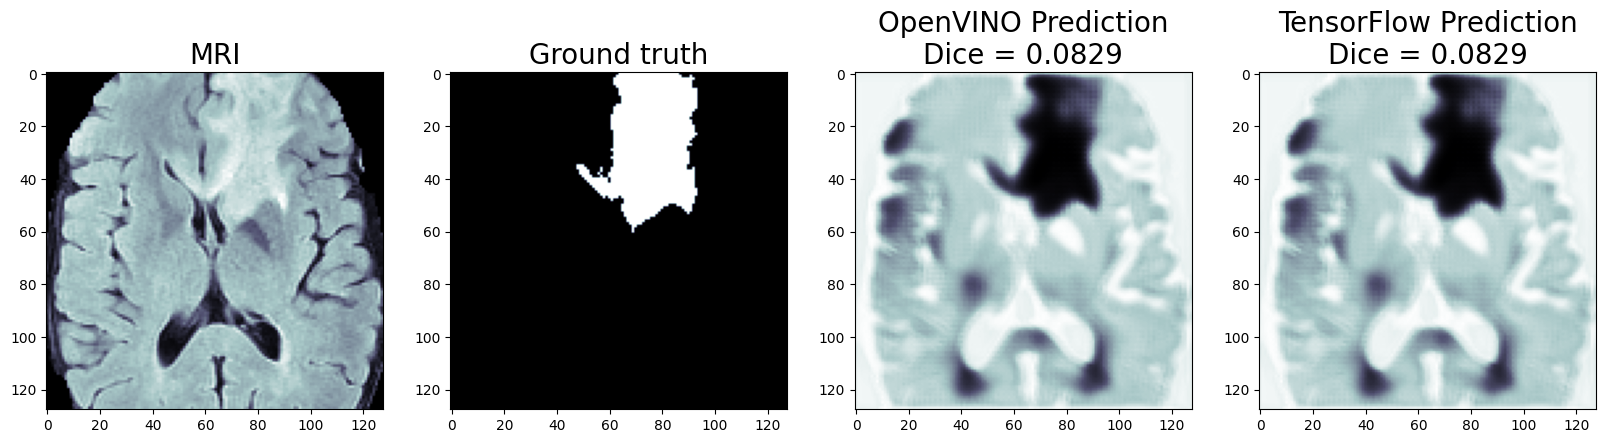

In [10]:
ds = brats_data.get_test().take(1).as_numpy_iterator()
for img, msk in ds:
    plot_predictions(img,msk)

OpenVINO inference time = 458.9970 msecs
1/1 [==============================] - 1s 1s/step
TensorFlow inference time = 1598.0089 msecs


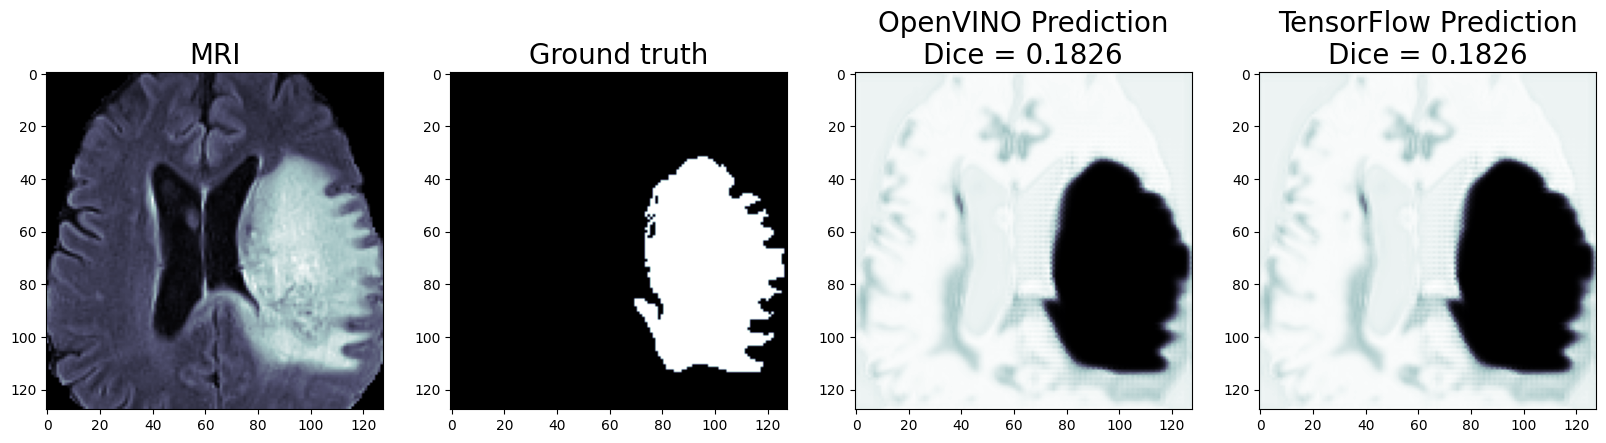

In [11]:
ds = brats_data.get_test().take(1).as_numpy_iterator()
for img, msk in ds:
    plot_predictions(img,msk)

OpenVINO inference time = 477.9961 msecs
1/1 [==============================] - 2s 2s/step
TensorFlow inference time = 1699.0082 msecs


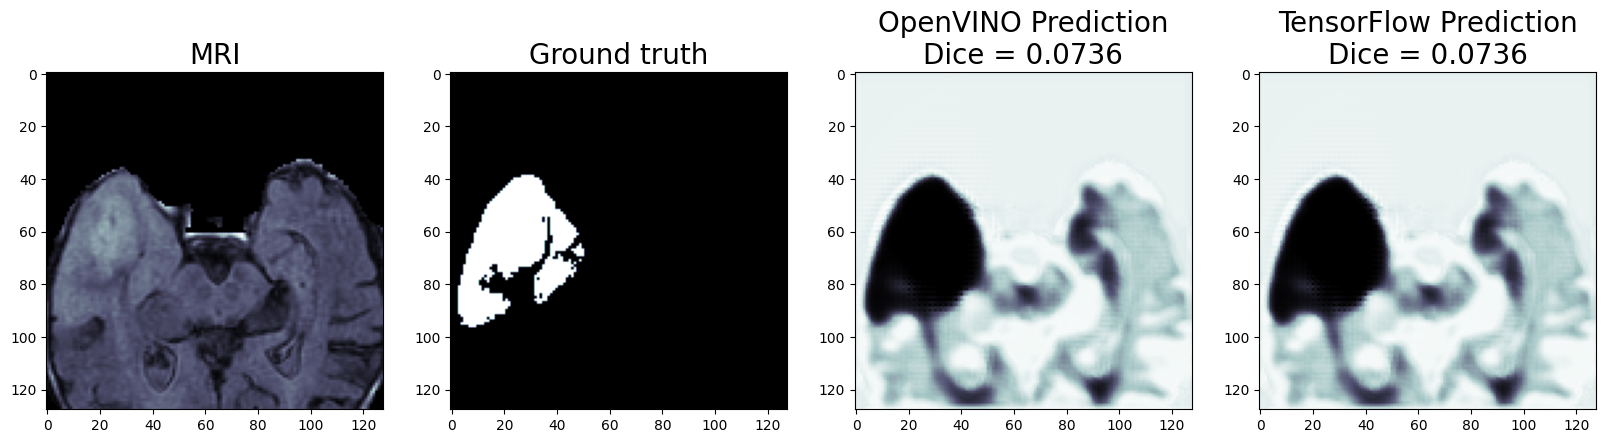

In [12]:
ds = brats_data.get_test().take(1).as_numpy_iterator()
for img, msk in ds:
    plot_predictions(img,msk)

OpenVINO inference time = 394.0003 msecs
1/1 [==============================] - 2s 2s/step
TensorFlow inference time = 1728.0052 msecs


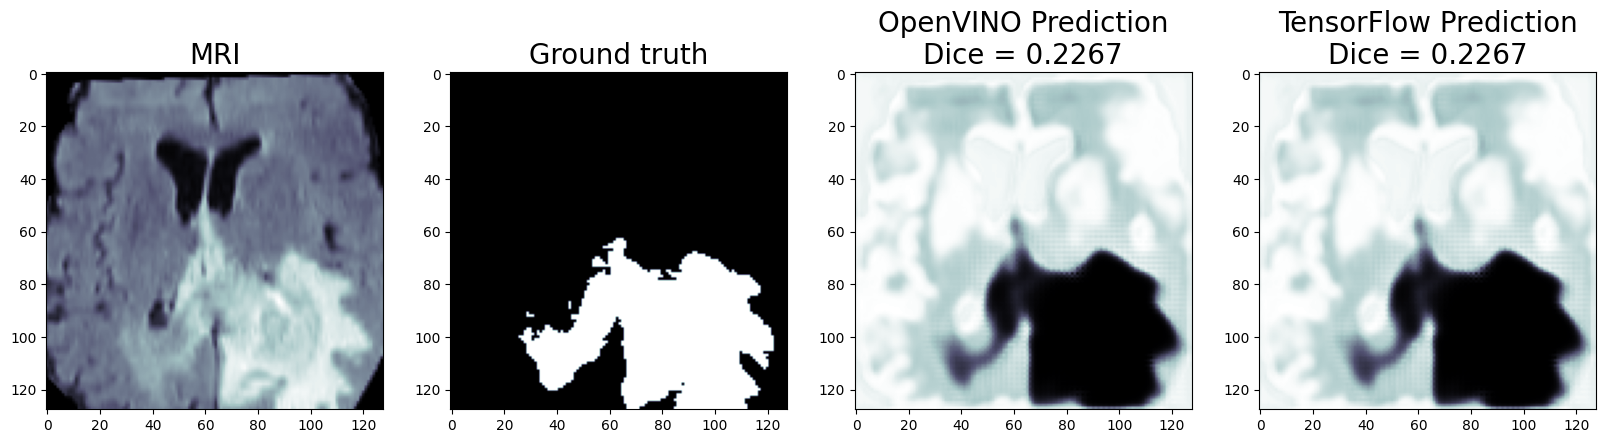

In [13]:
ds = brats_data.get_test().take(1).as_numpy_iterator()
for img, msk in ds:
    plot_predictions(img,msk)

*Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. SPDX-License-Identifier: EPL-2.0*

*Copyright (c) 2019-2020 Intel Corporation*